# ISIC Competitoin

# Libraries

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow" # other options: tensorflow or torch
import keras_cv
import keras

from keras import ops
import tensorflow as tf

import cv2

import pandas as pd
import numpy as np

from glob import glob
from tqdm.notebook import tqdm
import joblib

import matplotlib.pyplot as plt

Library Version

In [2]:
print(tf.__version__)
print(keras.__version__)
print(keras_cv.__version__)

2.16.1
3.3.3
0.9.0


# Configure Class 

In [3]:
class CFG:
    verbose = 1
    seed = 41 # randome seeding
    neg_sample = 0.01 # downsample negative class
    pos_sample = 5.0 # upsample positive class
    preset = "efficientnetv2_b2_imagenet" # pretrained model 
    
    image_size = [128,128] # Input image size 
    epochs = 8 # training epochs
    batch_size = 256
    lr_mode = 'cos'
    
    class_names = ['target']
    num_classes = 1
    

# Reproducibility
Setting value for random seed

In [4]:
keras.utils.set_random_seed(CFG.seed)

# Exploring Dataset

In [5]:
BASE_PATH = "/kaggle/input/isic-2024-challenge"

## Train_Dataset

In [6]:
df = pd.read_csv(f"{BASE_PATH}/train-metadata.csv",low_memory=False)
df = df.ffill()
display(df.head(2))

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455


## Test Dataset

In [7]:
test_df = pd.read_csv(f'{BASE_PATH}/test-metadata.csv')
test_df = test_df.ffill()
display(test_df.head(2))

,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,...,0.304827,1.281532,2.299935,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,...,0.000000,1.271940,2.011223,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland...",CC-BY


# ⚖️Balancing the Data

Data is significantly imbalanced, there are large number of negative samples compared to positive. 

### Solution
To Address 
* Downsample the negative class
* UP-Sample the positive class

In [8]:
print("No of Positive and Negative Values")
print(df.target.value_counts())

No of Positive and Negative Values
target
0    400666
1       393
Name: count, dtype: int64


In [9]:
print("Class Distribution Ratio before sampling")
display(df.target.value_counts(normalize = True)*100)

Class Distribution Ratio before sampling


target
0    99.902009
1     0.097991
Name: proportion, dtype: float64

## Sampling
downsampling the negative images

In [10]:
positive_df = df.query("target== 0").sample(frac = CFG.neg_sample,random_state = CFG.seed)
len(positive_df)


4007

## UpSampling the Negative Images
* Operation: This code increases the number of positive samples by sampling with replacement (replace=True). The frac=CFG.pos_sample (which is 5.0) means that each positive sample is likely duplicated multiple times until the size is approximately 5 times the original number of positive samples.
* Result: The original 393 positive samples are increased to 1,965 samples.
* Purpose: Upsampling the positive class helps in balancing the dataset by giving more weight to the minority class during training.

In [11]:
negative_df = df.query("target==1").sample(frac = CFG.pos_sample,random_state = CFG.seed,replace = True)

len(negative_df)

1965

Concatinating again

In [12]:
df = pd.concat([positive_df,negative_df],axis=0).sample(frac=1.0)
df

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
66974,ISIC_1728455,0,IP_0625501,35.0,female,lower extremity,2.63,TBP tile: close-up,3D: XP,25.241429,...,IL_9317140,Benign,Benign,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,<1/mm^2,0.2,99.999928
206309,ISIC_5190198,1,IP_4549819,70.0,male,anterior torso,1.43,TBP tile: close-up,3D: white,25.816622,...,IL_2199370,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular","Blue nevus, Cellular",>4/mm^2,1.7,98.307794
168747,ISIC_4257027,0,IP_2203964,65.0,male,lower extremity,4.35,TBP tile: close-up,3D: XP,25.427837,...,IL_5315405,Benign,Benign,Malignant melanocytic proliferations (Melanoma),Melanoma in situ,"Nevus, Congenital","Blue nevus, Cellular",0/mm^2,0.6,99.828488
327562,ISIC_8189932,0,IP_5714646,40.0,male,lower extremity,2.60,TBP tile: close-up,3D: XP,15.762610,...,IL_7634152,Benign,Benign,Benign melanocytic proliferations,Nevus,"Nevus, Atypical, Dysplastic, or Clark","Blue nevus, Cellular",<1/mm^2,0.3,99.963120
168462,ISIC_4249659,0,IP_5086285,70.0,male,lower extremity,4.05,TBP tile: close-up,3D: white,23.246528,...,IL_4136752,Benign,Benign,Benign melanocytic proliferations,Nevus,"Nevus, Congenital","Blue nevus, Cellular",0/mm^2,0.6,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238206,ISIC_5987936,1,IP_8721252,65.0,male,posterior torso,10.35,TBP tile: close-up,3D: white,26.072440,...,IL_9094061,Malignant::Malignant melanocytic proliferation...,Malignant,Malignant melanocytic proliferations (Melanoma),Melanoma in situ,"Melanoma in situ, associated with a nevus","Blue nevus, Cellular",<1/mm^2,0.5,99.999130
66722,ISIC_1721956,1,IP_3921915,45.0,male,posterior torso,6.39,TBP tile: close-up,3D: white,17.872925,...,IL_4346351,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,<1/mm^2,0.2,99.986887
230821,ISIC_5801447,0,IP_6547234,80.0,male,anterior torso,5.31,TBP tile: close-up,3D: XP,13.773070,...,IL_9084045,Benign,Benign,Indeterminate melanocytic proliferations,Atypical intraepithelial melanocytic prolifera...,"Nevus, Atypical, Dysplastic, or Clark","Blue nevus, Cellular",<1/mm^2,0.2,99.999240
16083,ISIC_0468552,0,IP_4041934,65.0,female,posterior torso,3.08,TBP tile: close-up,3D: white,30.881758,...,IL_3505443,Benign,Benign,Malignant melanocytic proliferations (Melanoma),Melanoma in situ,"Melanoma in situ, associated with a nevus",NaN,NaN,0.5,99.999988


In [13]:
print("Total Images we have",len(df))
print("Target",df.target.value_counts())

Total Images we have 5972
Target target
0    4007
1    1965
Name: count, dtype: int64


Ratio after Sampling

In [14]:
print("Ratio after Sampling")
display(df.target.value_counts(normalize = True)*100)

Ratio after Sampling


target
0    67.09645
1    32.90355
Name: proportion, dtype: float64

## Class Weights
Still after downsampling the difference is significant. So to adjust this problem we can *Assign Weights* to Class.

*To further address this imbalance during training, loss weighting will be used. This technique ensures that the model weights are updated more heavily for the positive samples, thereby reducing the bias towards the negative class. The following code computes the class weights for the loss:

In [15]:
from sklearn.utils.class_weight import compute_class_weight

### Breakdown of the Code
#### 1. Compute Class Weights:
* class_weight="balanced": This parameter tells the function to automatically adjust the weights inversely proportional to the class frequencies in the dataset. Classes that are underrepresented will get higher weights, while classes that are overrepresented will get lower weights.

* classes=np.unique(df['target']): This specifies the unique classes in the target variable df['target']. It ensures that the weights are calculated for all classes present in the target.

* y=df['target']: This is the target variable containing the class labels for which the weights are to be computed.

* The compute_class_weight function returns an array of weights corresponding to the classes in classes.

#### 2. Convert Weights to a Dictionary:
* This line converts the array of class weights into a dictionary, where each class label is mapped to its corresponding weight.

* enumerate(class_weights) pairs each class label (starting from 0) with its computed weight.

* dict(enumerate(class_weights)) creates a dictionary where the keys are the class labels (e.g., 0 and 1), and the values are the corresponding weights.

In [16]:
class_weights = compute_class_weight("balanced",classes= np.unique(df['target']),y=df['target'])

class_weights = dict(enumerate(class_weights))
print("Class Weights",class_weights)

Class Weights {0: 0.7451959071624656, 1: 1.519592875318066}


# Loading Images from hdf5 file

In [17]:
import h5py

In [18]:
# training and validation images 
training_validation_hdf5 = h5py.File(f"{BASE_PATH}/train-image.hdf5",'r')

# testing images
testing_images = h5py.File(f"{BASE_PATH}/test-image.hdf5",'r')                                 
print("DOnE")

DOnE


In [19]:
len(training_validation_hdf5)

401059

## Ploting Image

In [20]:
isic_id = df.isic_id.iloc[0]
isic_id

'ISIC_1728455'

In [21]:
# image as byte string

byte_string = training_validation_hdf5[isic_id][()]
print(f"Image in the Form of Byte Sting:{byte_string[:20]}")

Image in the Form of Byte Sting:b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00'


In [22]:
# convert byte string into np array
nparr = np.frombuffer( byte_string , np.uint8)
print(f"Image is the form of array \n{nparr}")

Image is the form of array 
[255 216 255 ... 159 255 217]


In [23]:
nparr.shape

(2953,)

In [24]:
nparr

array([255, 216, 255, ..., 159, 255, 217], dtype=uint8)

### Displaying the image
# BreakDown of Code
1. cv2.imdecode(nparr, cv2.IMREAD_COLOR):
    * nparr: This is a 1D NumPy array that represents the encoded image. It might be a JPEG or PNG image in binary form (e.g., read from a file, then converted into a NumPy array).
    * cv2.IMREAD_COLOR: This flag tells OpenCV to load the image in color (i.e., with 3 channels: Blue, Green, and Red).
* Operation:
    * cv2.imdecode() takes the encoded image data and decodes it back into an image matrix.
    * After decoding, the resulting matrix is a 3D NumPy array representing the image in BGR format, with dimensions (height, width, 3).
2.[..., ::-1]:

   * This operation performs slicing on the last axis (the color channels).
    * [..., ::-1] reverses the order of the color channels from BGR to RGB.
    * Operation:
    * The slice [..., ::-1] flips the 3rd dimension (i.e., the channels), changing the color format from OpenCV's default BGR to the more common RGB format.

In [25]:
image = cv2.imdecode(nparr , cv2.IMREAD_COLOR)[...,::-1]


In [26]:
image.shape

(183, 183, 3)

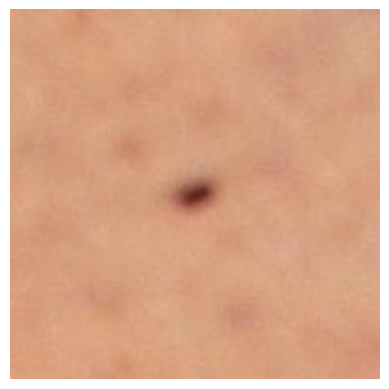

In [27]:
plt.axis('off')
plt.imshow(image)

# 🔪 | Data Split
In the following code,the data will be splitted into 5 stratified folds and use the first fold for training and validation. It's important to note that StratifiedGroupKFold is being used to ensure that patient_ids do not overlap between the training and validation datasets. This prevents data leakage, where the model could potentially peak at data it should not have access to.

The code you've provided is a process to split a DataFrame into training and validation sets using stratified group k-fold cross-validation. Here's a detailed explanation of each step:

### Step-by-Step Explanation

1. **Reset Index:**
   ```python
   df = df.reset_index(drop=True)
   ```
   - This resets the index of the DataFrame `df` to ensure it has a continuous index from `0` to `n-1`.
   - `drop=True` ensures that the old index is not added as a new column in the DataFrame.

2. **Initialize Fold Column:**
   ```python
   df["fold"] = -1
   ```
   - A new column named `"fold"` is added to the DataFrame and initialized to `-1` for all rows. This column will later be used to store the fold assignments for each data point.

3. **Initialize StratifiedGroupKFold:**
   ```python
   sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=CFG.seed)
   ```
   - `StratifiedGroupKFold` is a cross-validator from Scikit-learn that provides stratified splits while ensuring that the groups (in this case, `patient_id`) are not split across different folds.
   - `n_splits=5` means that the data will be split into 5 folds.
   - `shuffle=True` randomizes the data before splitting.
   - `random_state=CFG.seed` ensures that the splits are reproducible by controlling the randomness.

4. **Split Data into Folds:**
   ```python
   for i, (training_idx, validation_idx) in enumerate(sgkf.split(df, y=df.target, groups=df.patient_id)):
       df.loc[validation_idx, "fold"] = int(i)
   ```
   - The `split()` method is called on `sgkf` to generate the training and validation indices for each fold.
   - `y=df.target` tells the method to stratify the folds based on the `target` column. This ensures that each fold has a similar distribution of target classes.
   - `groups=df.patient_id` ensures that the splitting respects the `patient_id` groups, meaning data from the same patient will not be split between training and validation sets.
   - The loop iterates over each fold, and the fold number `i` is assigned to the corresponding rows in the `fold` column of the DataFrame.

5. **Create Training and Validation DataFrames:**
   ```python
   training_df = df.query("fold!=0")
   validation_df = df.query("fold==0")
   ```
   - After assigning folds, the code uses the first fold (`fold == 0`) as the validation set and the remaining folds (`fold != 0`) as the training set.
   - `training_df` contains all the data except the first fold.
   - `validation_df` contains only the data from the first fold.

6. **Output the Number of Training and Validation Samples:**
   ```python
   print(f"# Num Train: {len(training_df)} | Num Valid: {len(validation_df)}")
   ```
   - This line prints the number of samples in the training and validation sets.

### Summary
- The code first initializes a column to store fold assignments.
- It then uses `StratifiedGroupKFold` to split the data into 5 stratified folds, ensuring that the distribution of target classes is consistent across folds, and that the data is grouped by `patient_id`.
- Finally, it assigns the first fold as the validation set and the remaining folds as the training set.

This approach is particularly useful in scenarios where the data is grouped (e.g., multiple samples from the same patient), and you want to ensure that samples from the same group are not split between training and validation sets.

In [28]:
from sklearn.model_selection import StratifiedGroupKFold


In [29]:
df = df.reset_index(drop = True)


In [30]:
df['fold'] = -1

In [31]:
df.head(2)

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,fold
0,ISIC_1728455,0,IP_0625501,35.0,female,lower extremity,2.63,TBP tile: close-up,3D: XP,25.241429,...,Benign,Benign,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular",NaN,<1/mm^2,0.2,99.999928,-1
1,ISIC_5190198,1,IP_4549819,70.0,male,anterior torso,1.43,TBP tile: close-up,3D: white,25.816622,...,Malignant::Malignant adnexal epithelial prolif...,Malignant,Malignant adnexal epithelial proliferations - ...,Basal cell carcinoma,"Basal cell carcinoma, Nodular","Blue nevus, Cellular",>4/mm^2,1.7,98.307794,-1


In [32]:
sgkf = StratifiedGroupKFold(n_splits = 5, shuffle = True, random_state = CFG.seed)
sgkf

StratifiedGroupKFold(n_splits=5, random_state=41, shuffle=True)

In [33]:
for i , (training_idx, validation_idx) in enumerate(sgkf.split(df, y =df.target, groups = df.patient_id)):
    print(training_idx, validation_idx)
    df.loc[validation_idx , 'fold'] = int(i)
    

[   0    1    2 ... 5969 5970 5971] [   5    8   10 ... 5932 5934 5953]
[   0    1    2 ... 5969 5970 5971] [   3    4   11 ... 5965 5967 5968]
[   0    1    2 ... 5967 5968 5971] [   6    9   14 ... 5962 5969 5970]
[   0    1    2 ... 5968 5969 5970] [  17   18   20 ... 5959 5964 5971]
[   3    4    5 ... 5969 5970 5971] [   0    1    2 ... 5956 5961 5966]


use first fold for training and validation

In [34]:
training_df = df.query("fold != 0")
validation_df = df.query("fold == 0")

print(f'Num Train:{len(training_df)} | Num validation: {len(validation_df)}')


Num Train:4819 | Num validation: 1153


Class Distribution in Training

In [35]:
training_df.target.value_counts()

target
0    3245
1    1574
Name: count, dtype: int64

Class Distribution in Validation

In [36]:
validation_df.target.value_counts()

target
0    762
1    391
Name: count, dtype: int64

## 📊 | Tabular Features
In this competition, alongside image data, tabular features such as age, sex, and the location of the lesion are available. Previous competitions, like ISIC 2020, have demonstrated that incorporating these tabular features can significantly enhance model performance. A similar improvement is anticipated here.

The following code snippet provides a method for selecting which tabular features to include. It is encouraged to experiment with various combinations to determine the most effective set.

In [37]:
df.dtypes

isic_id                          object
target                            int64
patient_id                       object
age_approx                      float64
sex                              object
anatom_site_general              object
clin_size_long_diam_mm          float64
image_type                       object
tbp_tile_type                    object
tbp_lv_A                        float64
tbp_lv_Aext                     float64
tbp_lv_B                        float64
tbp_lv_Bext                     float64
tbp_lv_C                        float64
tbp_lv_Cext                     float64
tbp_lv_H                        float64
tbp_lv_Hext                     float64
tbp_lv_L                        float64
tbp_lv_Lext                     float64
tbp_lv_areaMM2                  float64
tbp_lv_area_perim_ratio         float64
tbp_lv_color_std_mean           float64
tbp_lv_deltaA                   float64
tbp_lv_deltaB                   float64
tbp_lv_deltaL                   float64


In [38]:
# categorical columns will be one hot encoded

categorical_columns = ["sex", "anatom_site_general",
            "tbp_tile_type","tbp_lv_location", ]


In [39]:
# Numeraical features which will be normalized
numerical_columns  = ["age_approx", "tbp_lv_nevi_confidence", "clin_size_long_diam_mm",
           "tbp_lv_areaMM2", "tbp_lv_area_perim_ratio", "tbp_lv_color_std_mean",
           "tbp_lv_deltaLBnorm", "tbp_lv_minorAxisMM", ]

In [40]:
# Merging into one list
FEAT_COLS = categorical_columns + numerical_columns

## Data Loader
This DataLoader is designed to process both images and tabular features simultaneously as inputs. It applies augmentations like flip and cutout, with additional options available such as random brightness, contrast, zoom, and rotation. Experimentation with different augmentations is encouraged. More details on the available augmentations in KerasCV can be found here.

Note: Unlike standard augmentations, these augmentations are applied to a batch, enhancing training speed and reducing CPU bottlenecks.

In [41]:
def build_augmenter():
    aug_layers = [
        keras_cv.layers.RandomCutout(height_factor = (0.02,0.06),
                                    width_factor = (0.02,0.06)),
        keras_cv.layers.RandomFlip(mode ='horizontal')
    ]
    
    # applying the augmentation to random samples
    aug_layers = [keras_cv.layers.RandomApply(x , rate = 0.5) for x in aug_layers]
    
    
    # build augmentation layer 
    augmenter = keras_cv.layers.Augmenter(aug_layers)
    
    def augment(inp, label):
        images = inp["images"]
        aug_data = {"images": images}
        aug_data = augmenter(aug_data)
        inp["images"] = aug_data["images"]
        return inp, label
    
    return augment

In [42]:
def build_decoder(with_labels=True, target_size=CFG.image_size):
    def decode_image(inp):
        # Read jpeg image
        file_bytes = inp["images"]
        image = tf.io.decode_jpeg(file_bytes)
        
        # Resize
        image = tf.image.resize(image, size=target_size, method="area")
        
        # Rescale image
        image = tf.cast(image, tf.float32)
        image /= 255.0
        
        # Reshape
        image = tf.reshape(image, [*target_size, 3])
        
        inp["images"] = image
        return inp
    def decode_label(label, num_classes):
        label = tf.cast(label, tf.float32)
        label = tf.reshape(label, [num_classes])
        return label

    def decode_with_labels(inp, label=None):
        inp = decode_image(inp)
        label = decode_label(label, CFG.num_classes)
        return (inp, label)

    return decode_with_labels if with_labels else decode_image


In [43]:
def build_dataset(
    isic_ids,
    hdf5,
    features,
    labels=None,
    batch_size=32,
    decode_fn=None,
    augment_fn=None,
    augment=False,
    shuffle=1024,
    cache=True,
    drop_remainder=False,
):
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)

    if augment_fn is None:
        augment_fn = build_augmenter()
        
    AUTO = tf.data.experimental.AUTOTUNE

    images = [None]*len(isic_ids)
    
    for i, isic_id in enumerate(tqdm(isic_ids, desc="Loading Images ")):
        images[i] = hdf5[isic_id][()]
        
    inp = {"images": images, "features": features}
    slices = (inp, labels) if labels is not None else inp

    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.cache() if cache else ds
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    
    if shuffle:
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt = tf.data.Options()
        opt.deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.prefetch(AUTO)
    return ds

## Builidng Dataset
In the following code, training and validation data loaders will be created.

In [44]:
# Train

print("# Training")
training_features = dict(training_df[FEAT_COLS])

training_ids = training_df.isic_id.values

training_labels = training_df.target.values

training_ds = build_dataset(training_ids, 
                            training_validation_hdf5, 
                            training_features, 
                            training_labels, 
                            batch_size=CFG.batch_size,
                            shuffle=True,
                            augment=True)

# Training


Loading Images :   0%|          | 0/4819 [00:00<?, ?it/s]

In [45]:
# Valid Data
print("# Validation Data")

validation_features = dict(validation_df[FEAT_COLS])

validation_ids = validation_df.isic_id.values

validation_labels = validation_df.target.values

validation_ds = build_dataset(validation_ids,
                              training_validation_hdf5,
                              validation_features,
                              validation_labels,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              augment=False)

# Validation Data


Loading Images :   0%|          | 0/1153 [00:00<?, ?it/s]

In [46]:
validation_ds

<_PrefetchDataset element_spec=({'images': TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), 'features': {'sex': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'anatom_site_general': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'tbp_tile_type': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'tbp_lv_location': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'age_approx': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'tbp_lv_nevi_confidence': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'clin_size_long_diam_mm': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'tbp_lv_areaMM2': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'tbp_lv_area_perim_ratio': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'tbp_lv_color_std_mean': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'tbp_lv_deltaLBnorm': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'tbp_lv_minorAxisMM': TensorSpec(shape=(

In [47]:
feature_space = keras.utils.FeatureSpace(
    {
    # Categorical features encoded as integers
        "sex": "string_categorical",
        "anatom_site_general": "string_categorical",
        "tbp_tile_type": "string_categorical",
        "tbp_lv_location": "string_categorical",
        # Numerical features to discretize
        "age_approx": "float_discretized",
        # Numerical features to normalize
        "tbp_lv_nevi_confidence": "float_normalized",
        "clin_size_long_diam_mm": "float_normalized",
        "tbp_lv_areaMM2": "float_normalized",
        "tbp_lv_area_perim_ratio": "float_normalized",
        "tbp_lv_color_std_mean": "float_normalized",
        "tbp_lv_deltaLBnorm": "float_normalized",
        "tbp_lv_minorAxisMM": "float_normalized",
    },
    output_mode="concat",
)

## Configuring a FeatureSpace
To set up how each tabular feature should be preprocessed, keras.utils.FeatureSpace is used. A dictionary is passsed to it that maps each feature name to a string describing its type.

* String Categorical Features:
   * Examples: sex, anotm_site_general
* Numerical Features:
    * Examples: tbp_lv_nevi_confidence, clin_size_long_diam_mm
    * Note: These features will be normalized.
* Numerical Discrete Features:
    * age_approx: Need to discretize this feature into a number of bins.
### Adapt Tabular Features
Before the FeatureSpace is used to build a model, it needs to be adapted to the training data. During adapt(), the FeatureSpace will:

* Index the set of possible values for categorical features.
* Compute the mean and variance for numerical features to normalize.
* Compute the value boundaries for the different bins for numerical features to discretize.
Note: adapt() should be called on a tf.data.Dataset that yields dictionaries of feature values – no labels.

In [48]:
training_ds_with_no_labels = training_ds.map(lambda x, _: x["features"])
feature_space.adapt(training_ds_with_no_labels)

At this point, the FeatureSpace can be called on a dictionary of raw feature values. It will return a single concatenated vector for each sample, combining encoded features.

In the code below, it can be noticed that even though  
12
  raw (tabular) features are used, after processing with FeatureSpace, a vector of size  
71
  is created. This is because operations like one-hot encoding are being applied here.

In [49]:
for x, _ in training_ds.take(1):
    preprocessed_x = feature_space(x["features"])
    print("preprocessed_x.shape:", preprocessed_x.shape)
    print("preprocessed_x.dtype:", preprocessed_x.dtype)

preprocessed_x.shape: (256, 71)
preprocessed_x.dtype: <dtype: 'float32'>


## Apply Feature Processing
Integrating feature space processing into the data pipeline before the model is crucial. This approach enables asynchronous, parallel preprocessing of data on the CPU, ensuring it is optimized before being fed into the model

In [50]:
training_ds = training_ds.map(
    lambda x, y: ({"images": x["images"],
                   "features": feature_space(x["features"])}, y), num_parallel_calls=tf.data.AUTOTUNE)

validation_ds = validation_ds.map(
    lambda x, y: ({"images": x["images"],
                   "features": feature_space(x["features"])}, y), num_parallel_calls=tf.data.AUTOTUNE)

Output Shape of a Batch
Verifying the shape of a batch sample is essential. This step ensures that the dataloader is generating inputs with the correct dimensions, which is critical for the model's performance.

In [51]:
batch = next(iter(validation_ds))

print("Images:",batch[0]["images"].shape)
print("Features:", batch[0]["features"].shape)
print("Targets:", batch[1].shape)

Images: (256, 128, 128, 3)
Features: (256, 71)
Targets: (256, 1)


## 🔍 | Loss & Metric¶
This competition utilizes the Partial Area Under the Curve (pAUC) metric for evaluation. In Keras, a similar metric is ROC AUC, which can be used for approximate evaluation. For optimizing our model, binary cross entropy (BCE) loss from Keras will be used.

It's important to note that BCE loss is sensitive to class imbalance. To mitigate this issue, the class weights will be used which is computed earlier. These weights will prioritize updating the model weights more strongly for the minority class (positive class), thereby mitigating class imbalance.

In [52]:
#AUC
auc = keras.metrics.AUC()

# Loss 
loss = keras.losses.BinaryCrossentropy(label_smoothing = 0.02)

## 🤖 Building Model
 
In this notebook, we're using the ***EfficientNetV2*** B2 backbone from KerasCV's pretrained models to extract features from images. For processing tabular data, Dense layers are used. The final layer (head) is a Dense layer with a sigmoid activation function. The sigmoid activation is chosen because the target is binary; softmax would've been selected if the target was multiclass.

In [53]:
# Define input layers
image_input = keras.Input(shape=(*CFG.image_size, 3), name="images")

feat_input = keras.Input(shape=(feature_space.get_encoded_features().shape[1],), name="features")

inp = {"images":image_input, "features":feat_input}

# Branch for image input
backbone = keras_cv.models.EfficientNetV2Backbone.from_preset(CFG.preset)
x1 = backbone(image_input)
x1 = keras.layers.BatchNormalization()(x1)
x1 = keras.layers.GlobalAveragePooling2D()(x1)
x1 = keras.layers.BatchNormalization()(x1)
x1 = keras.layers.Dropout(0.1)(x1)

# Branch for tabular/feature input
x2 = keras.layers.Dense(96, activation="selu")(feat_input)
x2 = keras.layers.Dense(128, activation="selu")(x2)
x2 = keras.layers.Dropout(0.1)(x2)

# Concatenate both branches
concat = keras.layers.Concatenate()([x1, x2])

# Output layer
out = keras.layers.Dense(1, activation="sigmoid", dtype="float32")(concat)


Compiling the Model

In [54]:
model = keras.models.Model(inp,out)


## Compiling the Model

In [55]:
model.compile(optimizer = keras.optimizers.Adam(learning_rate=1e-4),
             loss = loss,
             metrics = [auc])

In [56]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ images (InputLayer) │ (None, 128, 128,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficient_net_v2b2… │ (None, 4, 4,      │  8,769,374 │ images[0][0]      │
│ (EfficientNetV2Bac… │ 1408)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 4, 4,      │      5,632 │ efficient_net_v2… │
│ (BatchNormalizatio… │ 1408)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features            │ (None, 71)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1408)      │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 96)        │      6,912 │ features[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1408)      │      5,632 │ global_average_p… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     12,416 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1408)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 1536)      │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      1,537 │ concatenate_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,801,503 (33.58 MB)

 Trainable params: 8,713,583 (33.24 MB)

 Non-trainable params: 87,920 (343.44 KB)

# Plot the Model

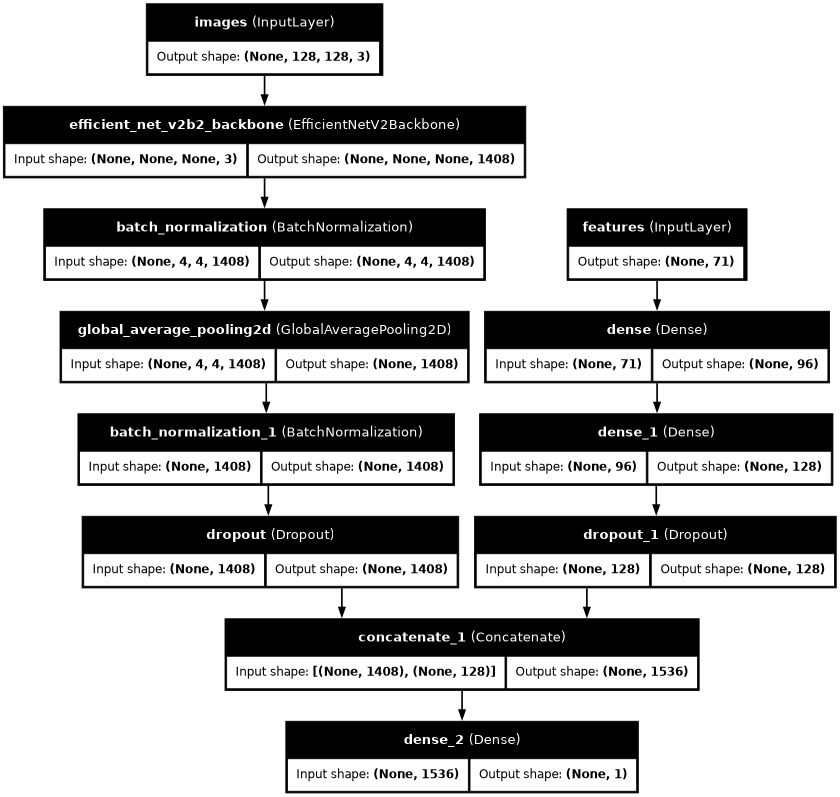

In [57]:
keras.utils.plot_model(model,show_shapes=True, show_layer_names=True , dpi=60)

## ⚓ | LR Schedule
A well-structured learning rate schedule is essential for efficient model training, ensuring optimal convergence and avoiding issues such as overshooting or stagnation.

In [58]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 2.5e-5, 5e-6 * batch_size, 0.8e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

## Plotting some images

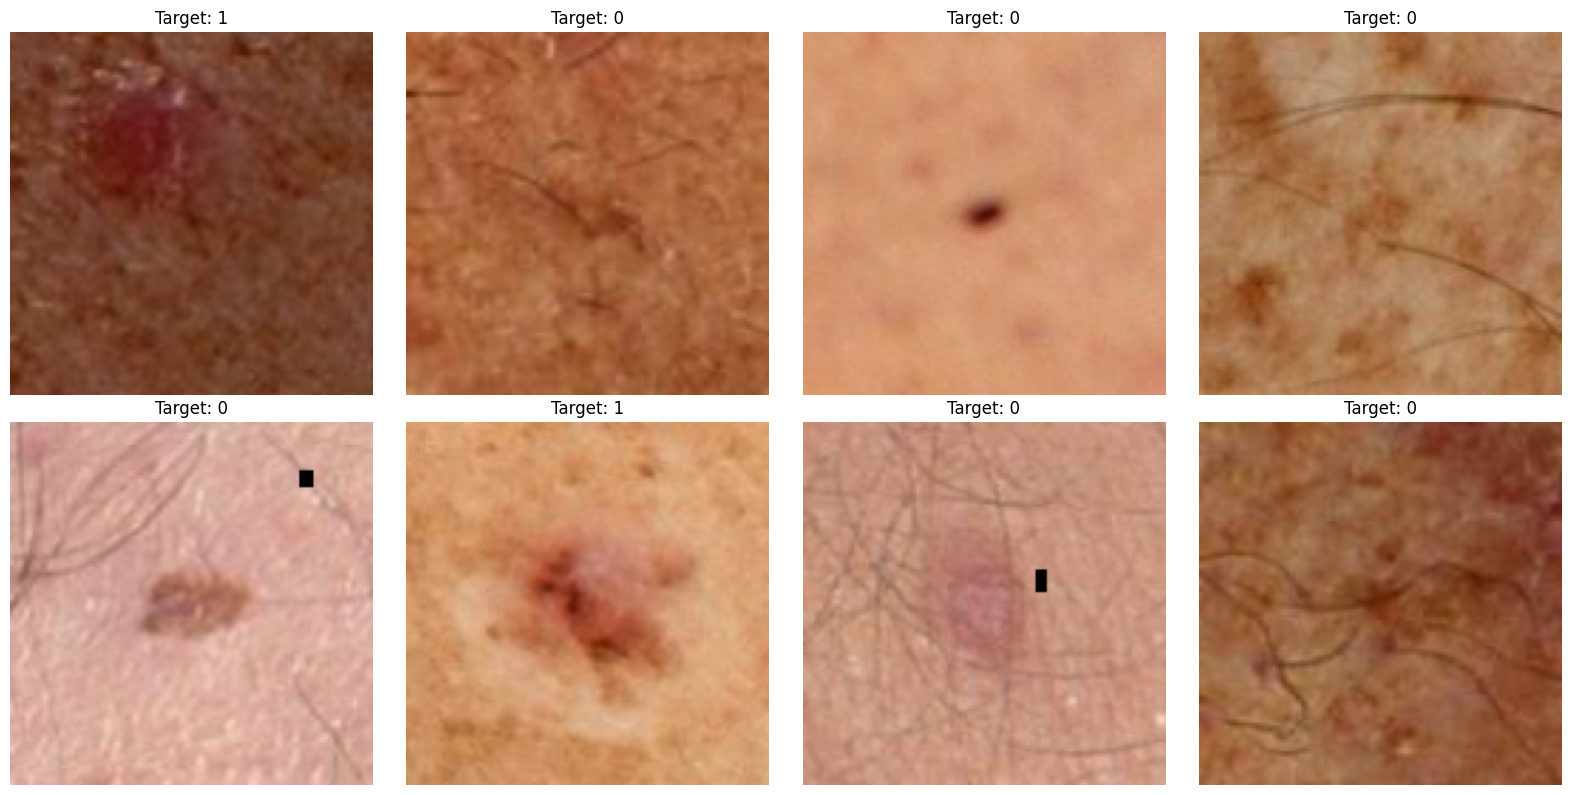

In [59]:
inputs, targets = next(iter(training_ds))
images = inputs["images"]
num_images, NUMERIC_COLUMNS = 8, 4

plt.figure(figsize=(4 * NUMERIC_COLUMNS, num_images // NUMERIC_COLUMNS * 4))
for i, (image, target) in enumerate(zip(images[:num_images], targets[:num_images])):
    plt.subplot(num_images // NUMERIC_COLUMNS, NUMERIC_COLUMNS, i + 1)
    image = image.numpy().astype("float32")
    target= target.numpy().astype("int32")[0]
    
    image = (image - image.min()) / (image.max() + 1e-4)

    plt.imshow(image)
    plt.title(f"Target: {target}")
    plt.axis("off")

plt.tight_layout()
plt.show()

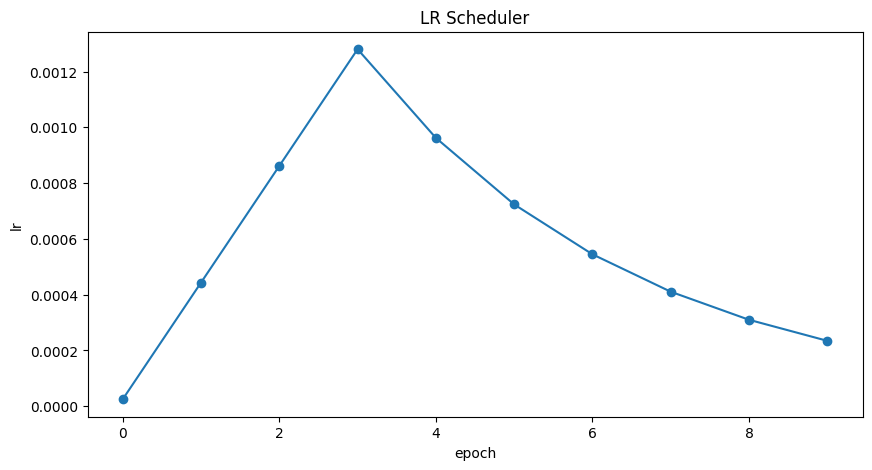

In [60]:
lr_cb = get_lr_callback(CFG.batch_size, mode="exp", plot=True)

## 💾 | Model Checkpoint
The ModelCheckpoint callback is used to save the model during training. It monitors the performance of the model on the validation data and saves the model with the best performance based on a specified metric.

Following setup ensures that the model with the highest validation AUC (val_auc) during training is saved to the file best_model.keras. Only the best model is saved, preventing overwriting with worse-performing models.

In [61]:
ckpt_cb = keras.callbacks.ModelCheckpoint(
    "best_model.keras",   # Filepath where the model will be saved.
    monitor="val_auc",    # Metric to monitor (validation AUC in this case).
    save_best_only=True,  # Save only the model with the best performance.
    save_weights_only=False,  # Save the entire model (not just the weights).
    mode="max",           # The model with the maximum 'val_auc' will be saved.
)

## 🚂 | Training

In [62]:
history = model.fit(
    training_ds,
    epochs=CFG.epochs,
    callbacks=[lr_cb, ckpt_cb],
    validation_data=validation_ds,
    verbose = CFG.verbose,
    class_weight=class_weights,
)

Epoch 1/8


I0000 00:00:1725363110.129028      68 service.cc:145] XLA service 0x7f6ba0002f90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725363110.129106      68 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1725363219.648539      68 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_11', 104 bytes spill stores, 132 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm3x_div_rn_noftz_f32_slowpath', 24 bytes spill stores, 24 bytes spill loads

I0000 00:00:1725363219.769484      68 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - auc: 0.4999 - loss: 0.8857

I0000 00:00:1725363329.445938      69 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_11', 104 bytes spill stores, 132 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm3x_div_rn_noftz_f32_slowpath', 24 bytes spill stores, 24 bytes spill loads



19/19 ━━━━━━━━━━━━━━━━━━━━ 288s 7s/step - auc: 0.5026 - loss: 0.8831 - val_auc: 0.3498 - val_loss: 0.6917 - learning_rate: 2.5000e-05
Epoch 2/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 38s 539ms/step - auc: 0.7937 - loss: 0.5784 - val_auc: 0.6874 - val_loss: 0.6031 - learning_rate: 4.4333e-04
Epoch 3/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 518ms/step - auc: 0.9534 - loss: 0.3005 - val_auc: 0.7834 - val_loss: 0.5452 - learning_rate: 8.6167e-04
Epoch 4/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 543ms/step - auc: 0.9895 - loss: 0.1733 - val_auc: 0.8957 - val_loss: 0.4424 - learning_rate: 0.0013
Epoch 5/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 515ms/step - auc: 0.9942 - loss: 0.1373 - val_auc: 0.9161 - val_loss: 0.4251 - learning_rate: 9.6200e-04
Epoch 6/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 457ms/step - auc: 0.9984 - loss: 0.1070 - val_auc: 0.9114 - val_loss: 0.4700 - learning_rate: 7.2350e-04
Epoch 7/8
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 526ms/step - auc: 0.9993 - loss: 0.0951 - val_auc: 0.9219 - val_loss: 0.4255 - learning_rate: 5.446

# ploting the Results

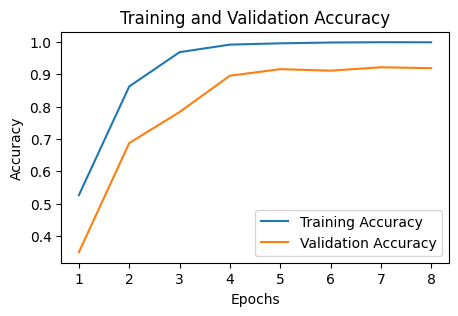

In [63]:
auc = history.history['auc']
val_auc = history.history['val_auc']

epochs = range(1, len(auc) + 1)

# Plot the training and validation accuracy
plt.figure(figsize=(5, 3))
plt.plot(epochs, auc, label='Training Accuracy')
plt.plot(epochs, val_auc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



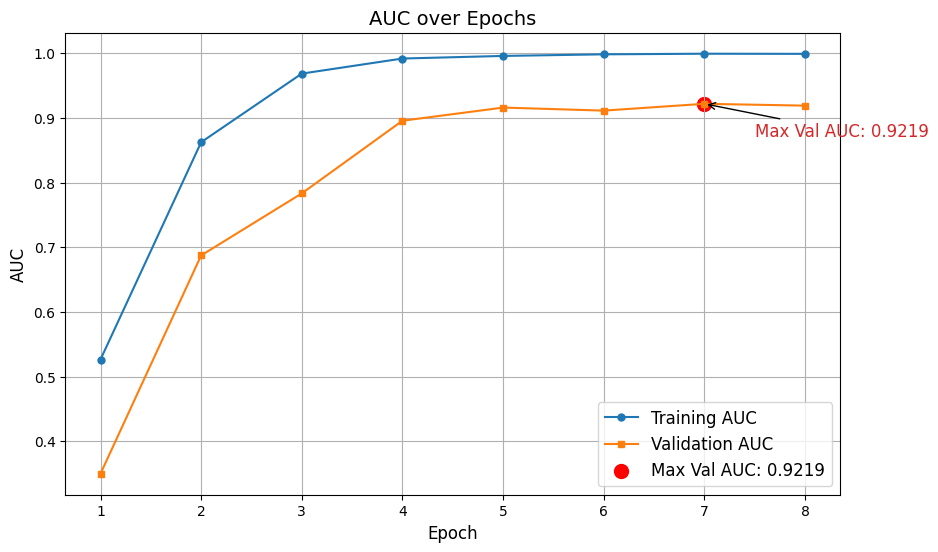

In [64]:
# Extract AUC and validation AUC from history
auc = history.history['auc']
val_auc = history.history['val_auc']
epochs = range(1, len(auc) + 1)

# Find the epoch with the maximum val_auc
max_val_auc_epoch = np.argmax(val_auc)
max_val_auc = val_auc[max_val_auc_epoch]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, auc, 'o-', label='Training AUC', markersize=5, color='tab:blue')
plt.plot(epochs, val_auc, 's-', label='Validation AUC', markersize=5, color='tab:orange')

# Highlight the max val_auc
plt.scatter(max_val_auc_epoch + 1, max_val_auc, color='red', s=100, label=f'Max Val AUC: {max_val_auc:.4f}')
plt.annotate(f'Max Val AUC: {max_val_auc:.4f}', 
             xy=(max_val_auc_epoch + 1, max_val_auc), 
             xytext=(max_val_auc_epoch + 1 + 0.5, max_val_auc - 0.05),
             arrowprops=dict(facecolor='black', arrowstyle="->"),
             fontsize=12,
             color='tab:red')

# Enhancing the plot
plt.title('AUC over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('AUC', fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True)
plt.xticks(epochs)

# Show the plot
plt.show()

# Results

In [65]:
best_score = max(history.history['val_auc'])
best_epoch = np.argmax(history.history['val_auc']) + 1
print("#" * 10 + " Result " + "#" * 10)
print(f"Best AUC: {best_score:.5f}")
print(f"Best Epoch: {best_epoch}")
print("#" * 28)

########## Result ##########
Best AUC: 0.92190
Best Epoch: 7
############################


# Prediction

## Load the model



In [66]:
model.load_weights("best_model.keras")

## Build Test Data

In [67]:

testing_hdf5 = h5py.File(f"{BASE_PATH}/test-image.hdf5", 'r')

In [68]:
# Testing
print("# Testing:")
testing_features = dict(test_df[FEAT_COLS])
testing_ids = test_df.isic_id.values
testing_ds = build_dataset(testing_ids, testing_hdf5,
                        testing_features, batch_size=CFG.batch_size,
                         shuffle=False, augment=False, cache=False)
# Apply feature space processing
testing_ds = testing_ds.map(
    lambda x: {"images": x["images"],
               "features": feature_space(x["features"])}, num_parallel_calls=tf.data.AUTOTUNE)

# Testing:


Loading Images :   0%|          | 0/3 [00:00<?, ?it/s]

Inference

In [69]:
preds = model.predict(testing_ds).squeeze()

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


In [70]:
preds

array([0.01666438, 0.00284508, 0.01057801], dtype=float32)

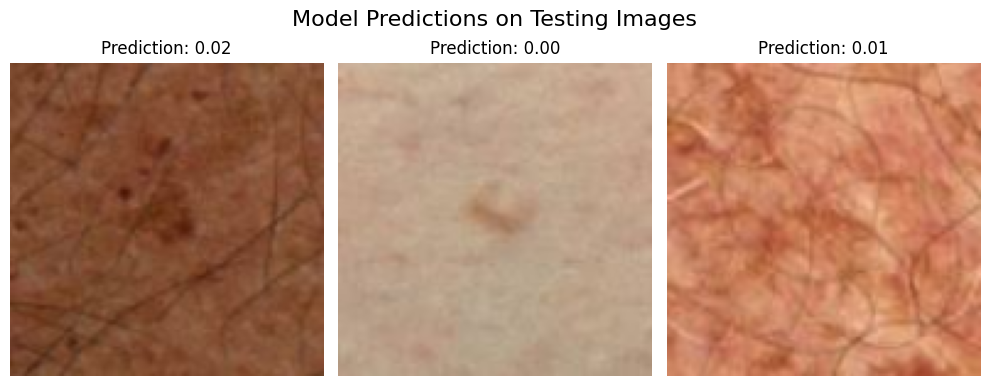

In [71]:
inputs = next(iter(testing_ds))
images = inputs["images"]

# Plotting
plt.figure(figsize=(10, 4))

for i in range(3):
    plt.subplot(1, 3, i+1)  # 1 row, 3 columns, i+1th subplot
    plt.imshow(images[i])  # Show image
    plt.title(f'Prediction: {preds[i]:.2f}')  # Set title with prediction
    plt.axis('off')  # Hide axis

plt.suptitle('Model Predictions on Testing Images', fontsize=16)
plt.tight_layout()
plt.show()

In [72]:
pred_df = test_df[["isic_id"]].copy()
pred_df["target"] = preds.tolist()

sub_df = pd.read_csv(f'{BASE_PATH}/sample_submission.csv')
sub_df = sub_df[["isic_id"]].copy()
sub_df = sub_df.merge(pred_df, on="isic_id", how="left")
sub_df.to_csv("submission.csv", index=False)
sub_df.head()

,isic_id,target
0,ISIC_0015657,0.016664
1,ISIC_0015729,0.002845
2,ISIC_0015740,0.010578
